In [162]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from calibrate import loss_function, calculate_ask_price
import matplotlib.pyplot as plt
from utils import display_order_book, to_float, to_json, extract_trades
from tqdm import tqdm
from orderBook import OrderBook, DollarsAndShares, PriceSizePairs, DynamicOrderBook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
plt.rcParams['figure.figsize'] = (14, 8)

# Загрузка данных, обработка bids и asks.

In [163]:
df = pd.read_csv('data/OrderBook.csv', index_col=0)

df.bids = df.bids.apply(to_json)
df.asks = df.asks.apply(to_json)

df.bids = df.bids.apply(to_float)
df.asks = df.asks.apply(to_float)

df

,figi,depth,isConsistent,bids,asks,time,limitUp,limitDown,instrumentUid,orderBookType
id,,,,,,,,,,
1,BBG004730RP0,10,True,"[[122.55, 1.0], [122.54, 52.0], [122.53, 141.0...","[[122.57, 1.0], [122.58, 10.0], [122.59, 41.0]...",2024-11-22 07:48:31.826,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
2,BBG004730RP0,10,True,"[[122.55, 1.0], [122.53, 1.0], [122.52, 160.0]...","[[122.56, 41.0], [122.57, 211.0], [122.58, 717...",2024-11-22 07:48:32.306,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
3,BBG004730RP0,10,True,"[[122.55, 1.0], [122.54, 52.0], [122.53, 141.0...","[[122.57, 1.0], [122.58, 10.0], [122.59, 41.0]...",2024-11-22 07:48:31.989,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
4,BBG004730RP0,10,True,"[[122.53, 60.0], [122.52, 101.0], [122.51, 962...","[[122.56, 42.0], [122.57, 42.0], [122.58, 707....",2024-11-22 07:48:32.486,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
5,BBG004730RP0,10,True,"[[122.53, 71.0], [122.52, 101.0], [122.51, 762...","[[122.56, 64.0], [122.57, 42.0], [122.58, 707....",2024-11-22 07:48:32.936,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
...,...,...,...,...,...,...,...,...,...,...
10507,BBG004730RP0,10,True,"[[121.53, 5.0], [121.52, 101.0], [121.51, 364....","[[121.54, 10.0], [121.55, 572.0], [121.56, 1.0...",2024-11-22 09:07:38.593,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
10508,BBG004730RP0,10,True,"[[121.53, 5.0], [121.52, 101.0], [121.51, 374....","[[121.54, 10.0], [121.55, 572.0], [121.56, 1.0...",2024-11-22 09:07:39.087,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE
10509,BBG004730RP0,10,True,"[[121.53, 5.0], [121.52, 101.0], [121.51, 374....","[[121.54, 10.0], [121.55, 572.0], [121.56, 1.0...",2024-11-22 09:07:39.396,"""{\""units\"":\""131\"",\""nano\"":790000000}""","""{\""units\"":\""110\"",\""nano\"":640000000}""",962e2a95-02a9-4171-abd7-aa198dbe643a,ORDERBOOK_TYPE_EXCHANGE


In [164]:
# # 1) Преобразуем колонку time в datetime
# df['time'] = pd.to_datetime(df['time'], format='mixed')

# # 2) Делаем её индексом
# df.set_index('time', inplace=True)

# df_minutely = df.resample('1s').agg({
#     'depth': 'last',
#     'isConsistent': 'last',
#     'bids': 'last',
#     'asks': 'last',
#     'limitUp': 'last',
#     'limitDown': 'last',
#     'instrumentUid': 'last'
# })

# # 4) Если в некоторые минуты нет записей,
# #    появятся строки с NaN в резульате — можно удалить их:
# df_minutely.dropna(how='all', inplace=True)
# df = df_minutely.copy()

# Размерность bids и asks = $N \times depth \times 2$;
## $depth = C$, обычно $depth = 10$.

In [165]:
start_train_idx = np.random.randint(0, 10000)
end_train_idx = start_train_idx + np.random.randint(50, 200)

start_val_idx = end_train_idx + 1
end_val_idx = start_val_idx + 2

start_train_idx, end_train_idx, end_train_idx - start_train_idx

(3665, 3738, 73)

In [166]:
bids = []
asks = []

for i in range(start_train_idx, end_train_idx):
    
    bids.append([DollarsAndShares(
            dollars=x[0],
            shares=x[1]
        ) for x in df.bids.iloc[i]])
    
    asks.append([DollarsAndShares(
        dollars=x[0],
        shares=x[1]
    ) for x in df.asks.iloc[i]])
    
order_books = [DynamicOrderBook(descending_bids=bids[i], ascending_asks=asks[i]) for i in range(len(bids))]

# Извлечение трейдов из исторических данных

In [167]:
trades = extract_trades(order_books)

n_t = end_train_idx

trades_til_n = [] # трейды до момента времени н
times_til_n = [] # моменты трейдов до времени н

for i in tqdm(range(len(trades))):
    if trades[i][0] < n_t:
        trades_til_n.append(trades[i][1])
        times_til_n.append(trades[i][0])
        
trades_til_n = np.array(trades_til_n)
times_til_n = np.array(times_til_n)

trade_times = times_til_n
trade_volumes = trades_til_n

n = len(trade_times)
n

100%|██████████| 97/97 [00:00<00:00, 1620906.33it/s]


97

# Калибровка параметра $\lambda$

In [168]:
import numpy as np
import statsmodels.api as sm


mid_prices = np.array([order_books[i].mid_price() for i in trade_times])
trades = extract_trades(order_books)

trades_tmp = []
for i in range(len(trade_times)):
    trades_tmp.append(trades[i][1])
    
trades_tmp = np.array(trades_tmp)

X_cum = np.cumsum(trades_tmp)


# Строим такую регрессию: $V_t - V_0$ = $\lambda(X_t - X_0)$

In [169]:
V0 = mid_prices[0]
X0 = X_cum[0]


y = mid_prices - V0
# X = X_cum - X0

X_total = X_cum[-1] - X0
X = X_cum - X0

print("Δmid_prices =", np.max(y) - np.min(y))
print("ΔX_cum =", np.max(X) - np.min(X))


import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Пусть y и X - это наши массивы, где:
# y = mid_prices - V0
# X = X_cum - X0

# 1) Масштабируем данные
scaler_y = StandardScaler()
scaler_X = StandardScaler()

# Преобразуем y и X в двумерный вид (требование scikit-learn),
# затем обратно превращаем в одномерный
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
X_scaled = scaler_X.fit_transform(X.reshape(-1, 1)).ravel()

X_design = sm.add_constant(X)
robust_model = sm.RLM(y, X_design, M=sm.robust.norms.HuberT())  # Можно менять функцию потерь
robust_results = robust_model.fit()
print(robust_results.summary())

alpha_opt = robust_results.params[0]
lambda_est = robust_results.params[1]

lambda_est


Δmid_prices = 0.12999999999999545
ΔX_cum = 17221.0
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   97
Model:                            RLM   Df Residuals:                       95
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 20 May 2025                                         
Time:                        01:45:09                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

np.float64(9.942780090654282e-06)

In [170]:
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

# Данные
V0 = mid_prices[0]
X0 = X_cum[0]
y = mid_prices - V0
X = X_cum - X0
# X_total = X_cum[-1] - X0
# X = (X_cum - X0) / X_total

print("Δmid_price =", np.max(y) - np.min(y))
print("ΔX =", np.max(X) - np.min(X))
print("X_total =", X_total)


# Масштабируем (как раньше)
scaler_y = StandardScaler()
scaler_X = StandardScaler()

# y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
# X_scaled = scaler_X.fit_transform(X.reshape(-1, 1)).ravel()

# --- Функция потерь (MAE, можно заменить на MSE и т.п.)
def loss_fn(params, X, y):
    alpha, lambd = params
    y_pred = alpha + lambd * X
    residuals = y - y_pred
    return np.mean((y - y_pred) ** 2)  # Или np.mean(residuals**2) для MSE

# --- Ограничения: λ > 0
bounds = [(-np.inf, np.inf), (1e-3, 1e+6)]

# --- Запускаем оптимизацию
res = minimize(
    fun=loss_fn,
    x0=[0.0, 0.01],           # стартовые значения: α и λ
    args=(X, y),
    bounds=bounds,
    method='L-BFGS-B'         # метод с поддержкой ограничений
)

# --- Получаем результат
alpha_opt, lambda_est = res.x
print(f"\nОптимальные параметры:")
print(f"  α     = {alpha_opt}")
print(f"  λ     = {lambda_est}")
print(f"  Успешно? {res.success}, Сообщение: {res.message}")


Δmid_price = 0.12999999999999545
ΔX = 17221.0
X_total = 17221.0

Оптимальные параметры:
  α     = -9.521979336083978
  λ     = 0.001
  Успешно? True, Сообщение: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


# Калибровка параметра $\rho$

In [171]:
trade_times = times_til_n
trade_volumes = trades_til_n

asks = np.array([order_books[i].ask_price() for i in trade_times])

fixed_k = 1/abs(lambda_est)

initial_r = [0.1]
spread = order_books[0].bid_ask_spread()  # s
mid_price = order_books[0].mid_price()    # V_t

# Оптимизируем только r при фиксированном k
result = minimize(
    loss_function,
    initial_r,
    args=(trade_times, trade_volumes, np.array(asks), spread, mid_price, fixed_k),
    bounds=[(1e-9, 70)],  # Ограничения только для r
    method='trust-constr'
)

optimized_r = result.x[0]

print("k:", fixed_k)
print("r_opt:", optimized_r)

k: 1000.0
r_opt: 13.353384564437432


In [172]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize

# Предположим, что true_ask_prices – это массив истинных ask-цен (для trade_times)
# Вычисляем параметры масштабирования на основе истинных цен:
true_min = np.min(asks)
true_max = np.max(asks)

def loss_function_fixed(
    r_param: float,
    trade_times: np.ndarray,
    trade_volumes: np.ndarray,
    true_ask_prices: np.ndarray,
    s: float,
    V_t,
    k
):
    """
    Функция потерь для оценки параметра r при фиксированном k.
    Масштабирование выполняется с использованием фиксированных параметров, полученных от истинных ask-цен.
    """
    r = r_param[0]
    
    # Вычисляем смоделированные ask-цены для каждого времени
    modeled_ask_prices = np.array([
        calculate_ask_price(t, trade_times, trade_volumes, k, r, s, V_t)[0]
        for t in trade_times
    ])
    
    # Масштабирование с использованием фиксированных true_min и true_max
    true_ask_prices_sc = (true_ask_prices - true_min) / (true_max - true_min)
    modeled_ask_prices_sc = (modeled_ask_prices - true_min) / (true_max - true_min)
    
    return np.mean((true_ask_prices_sc - modeled_ask_prices_sc) ** 2)

# Пример оптимизации параметра r при фиксированном k:
fixed_k = 1 / abs(lambda_est)  # lambda_est должен быть определён
initial_r = [0.1]
result = minimize(
    loss_function_fixed,
    initial_r,
    args=(trade_times, trade_volumes, asks, spread, mid_price, fixed_k),
    bounds=[(1e-9, 70)],
    method='trust-constr'
)
optimized_r = result.x[0]
print("Оптимальное r:", optimized_r)

# Функция потерь только от r (оборачиваем r в список)
def loss_r(r):
    return loss_function_fixed([r], trade_times, trade_volumes, asks, spread, mid_price, fixed_k)

# Проверка аппроксимации второй производной для разных значений eps
def check_second_derivative(r_opt, eps_values):
    for eps in eps_values:
        loss_minus = loss_r(r_opt - eps)
        loss_plus = loss_r(r_opt + eps)
        loss_opt = loss_r(r_opt)
        second_deriv = (loss_plus - 2 * loss_opt + loss_minus) / (eps ** 2)
    return

epsilons = [1e-5, 1e-4, 1e-3, 1e-2]
check_second_derivative(optimized_r, epsilons)

# Выбор eps для окончательной оценки
eps_stable = 1e-3
loss_minus = loss_r(optimized_r - eps_stable)
loss_plus = loss_r(optimized_r + eps_stable)
loss_opt = loss_r(optimized_r)
second_deriv = (loss_plus - 2 * loss_opt + loss_minus) / (eps_stable ** 2)
print(f"\nПри ε = {eps_stable} вторая производная = {second_deriv}")

if np.abs(second_deriv) < 1e-12:
    print("Вторая производная слишком мала – функция потерь почти плоская в окрестности оптимума.")
    std_error_r = np.inf
else:
    variance_r = 1 / second_deriv
    std_error_r = np.sqrt(variance_r)
    print("Стандартная ошибка для r:", std_error_r)

if np.isfinite(std_error_r) and std_error_r > 0:
    t_statistic = optimized_r / std_error_r
    print("t-статистика для r:", t_statistic)
else:
    print("t-статистика для r не может быть рассчитана, так как стандартная ошибка не определена.")


Оптимальное r: 19.871780773828352

При ε = 0.001 вторая производная = 0.0
Вторая производная слишком мала – функция потерь почти плоская в окрестности оптимума.
t-статистика для r не может быть рассчитана, так как стандартная ошибка не определена.


# Моделирование аск прайса
# Инициализация параметров

In [173]:
# bids = []
# asks = []

# for i in range(start_val_idx, end_val_idx):
    
#     bids.append([DollarsAndShares(
#             dollars=x[0],
#             shares=x[1]
#         ) for x in df.bids.iloc[i]])
    
#     asks.append([DollarsAndShares(
#         dollars=x[0],
#         shares=x[1]
#     ) for x in df.asks.iloc[i]])
    
# order_books = [DynamicOrderBook(descending_bids=bids[i], ascending_asks=asks[i]) for i in range(len(bids))]

# real_asks = np.array([order_books[i].ask_price() for i in range(len(order_books))])


In [174]:
lmbd = lambda_est
s = order_books[0].bid_ask_spread()
r = optimized_r

N = len(order_books) - 1
T = 1.0 
dt = T / N
t_grid = np.linspace(0, T, N+1)
t_grid.shape

(73,)

# Моделируем цену $F_t$ как броуновское движение $W_t$

In [175]:
import numpy as np

def calibrate_sigma(order_books, dt_sec: float = 1.0) -> float:
    """
    Оценивает σ (волатильность броуновского движения mid-price) 
    из последовательности стаканов или уже готового ряда цен.

    Параметры
    ----------
    order_books : Iterable[DynamicOrderBook] | Iterable[float]
        Либо объекты, у которых есть метод .mid_price(), 
        либо сразу массив mid-цен.
    dt_sec : float, default 1.0
        Шаг дискретизации данных в секундах (после ресемплинга).

    Возвращает
    ----------
    sigma_hat : float
        Оценка σ в единицах √секунды («per sqrt-second»), 
        то есть такая, что Var[ΔF_t] = σ² dt.

    Пример
    -------
    >>> sigma = calibrate_sigma(train_books)      # train_books — список DynamicOrderBook
    >>> sigma
    0.0037
    """
    # 1) Извлекаем mid-цены
    mids = np.fromiter(
        (ob.mid_price() if hasattr(ob, "mid_price") else float(ob)
         for ob in order_books),
        dtype=float
    )
    # 2) Удаляем NaN
    mids = mids[~np.isnan(mids)]
    if len(mids) < 2:
        raise ValueError("Недостаточно точек для оценки σ.")

    # 3) Лог-доходности
    r = np.diff(np.log(mids))

    # 4) σ для шага dt_sec
    sigma_hat = r.std(ddof=1) / np.sqrt(dt_sec)

    return sigma_hat


Simulating F_t paths: 100%|██████████| 1000/1000 [00:00<00:00, 17823.07it/s]


(73,)

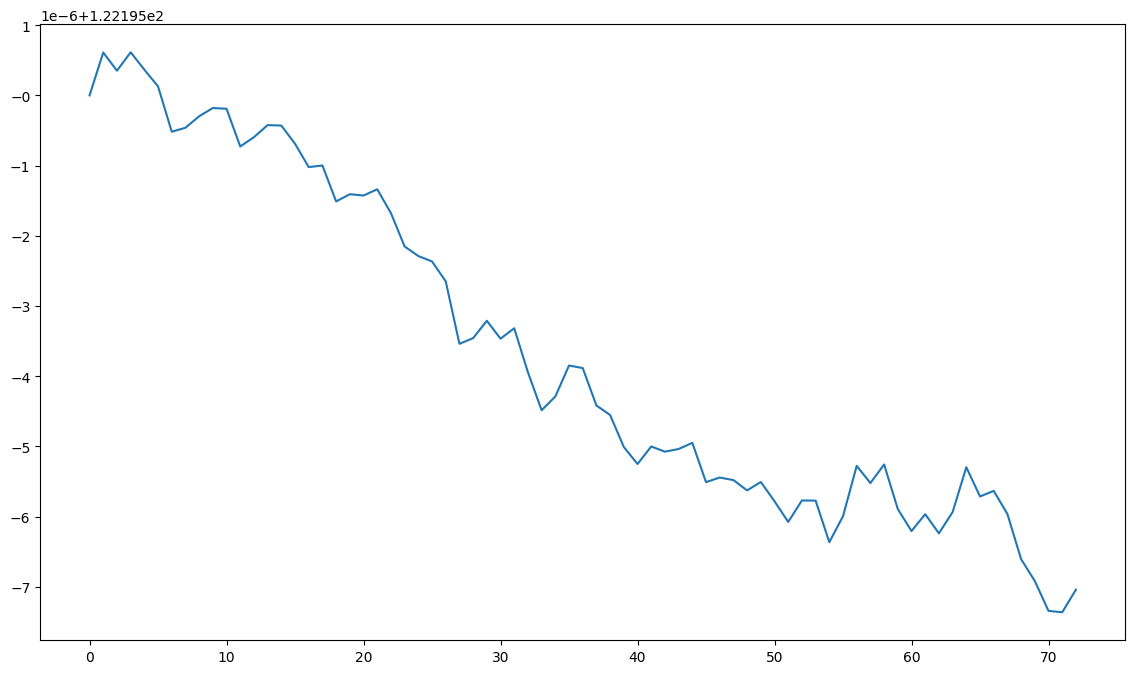

In [176]:
n_sim = 1_000
mu = 0.0
sigma = sigma_hat = calibrate_sigma(order_books)

def simulate_mid_price_paths(order_books, n_sim=1000, mu=0.0, sigma=0.5, T=1.0):
    """
    Генерация траекторий mid-price F_t с броуновским движением.

    Parameters:
        order_books : список order book’ов (ожидается, что у них есть .mid_price())
        n_sim       : количество симуляций
        mu          : дрейф броуновского движения
        sigma       : волатильность
        T           : горизонт моделирования (в тех же единицах, что и частота стакана)

    Returns:
        F_result : массив (n_sim, N+1) — симулированные траектории
        F_mean   : средняя траектория F_t (усреднение по симам)
        t_grid   : массив времени (N+1,)
    """
    F0 = order_books[0].mid_price()
    N = len(order_books) - 1
    dt = T / N
    t_grid = np.linspace(0, T, N+1)

    F_result = np.empty((n_sim, N+1), dtype=np.float64)

    for sim in tqdm(range(n_sim), desc="Simulating F_t paths"):
        z = np.random.randn(N)
        F = np.empty(N+1, dtype=np.float64)
        F[0] = F0
        for i in range(1, N+1):
            F[i] = F[i-1] + mu * dt + sigma * np.sqrt(dt) * z[i-1]
        F_result[sim, :] = F

    F_mean = np.mean(F_result, axis=0)
    return F_result, F_mean, t_grid


F_result, F, t_grid = simulate_mid_price_paths(order_books, n_sim=n_sim, mu=mu, sigma=sigma, T=T)
plt.plot(F)
t_grid.shape

In [177]:
# Преобразуем сделки в формат (normalized_t, trade_value) с учётом временной сетки
trades_history = [(t_grid[t_idx], x_val) for (t_idx, x_val) in trades]
# scale = 1 / X_total
# trades_history = [(t, x * scale) for (t, x) in trades]

# Рассчет $X_t$

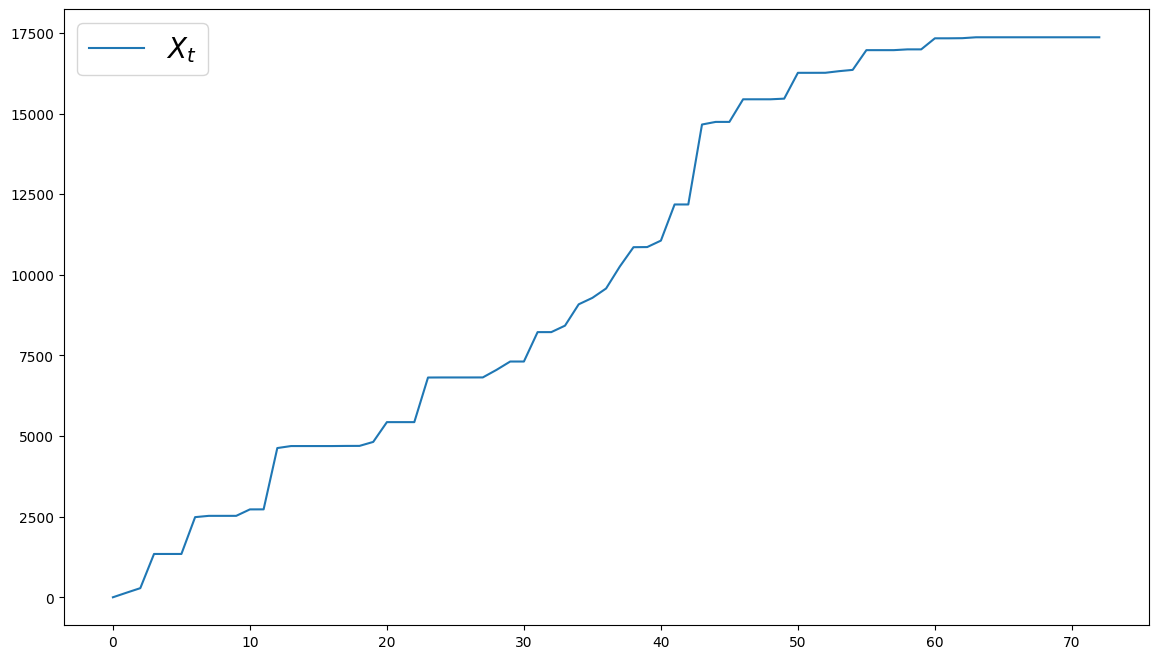

In [178]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def simulate_X_t(n_sim, t_grid, trades_history):
    """
    Для каждого симуляционного запуска и для каждого момента времени из t_grid
    вычисляет кумулятивную сумму сделок (сумма x_val для сделок с tau <= t).
    
    Parameters:
      n_sim : int
          Число симуляций.
      t_grid : 1D numpy array (np.float64)
          Моменты времени, для которых считается кумулятивная сумма.
      trades_history : 2D numpy array (np.float64) с формой (n_trades, 2)
          История сделок, где trades_history[:, 0] – tau, а trades_history[:, 1] – x_val.
          
    Returns:
      X_res : 2D numpy array (n_sim, len(t_grid))
          Для каждой симуляции массив кумулятивных сумм.
    """
    n_time = t_grid.shape[0]
    n_trades = trades_history.shape[0]
    X_res = np.empty((n_sim, n_time), dtype=np.float64)
    
    # Для каждой симуляции
    for sim in prange(n_sim):
        # Массив для хранения кумулятивных сумм для текущей симуляции
        X_local = np.empty(n_time, dtype=np.float64)
        # Обычно в начальный момент (t_grid[0]) кумулятивная сумма равна 0
        X_local[0] = 0.0
        # Для каждого момента времени, начиная с 1 (так как для 0 уже задано)
        for i in range(1, n_time):
            cum_sum = 0.0
            current_time = t_grid[i]
            # Проходим по истории сделок
            for j in range(n_trades):
                tau = trades_history[j, 0]
                if tau <= current_time:
                    cum_sum += trades_history[j, 1]
                else:
                    break  # trades_history отсортирован по времени tau
            X_local[i] = cum_sum
        X_res[sim, :] = X_local
    return X_res

t_grid = np.asarray(t_grid, dtype=np.float64)
trades_history = np.asarray(trades_history, dtype=np.float64)
n_sim = int(n_sim)

# Вычисляем результаты симуляций
X_res = simulate_X_t(n_sim, t_grid, trades_history)
# Усредняем по симуляциям, чтобы получить итоговый X_t
X_t = np.mean(X_res, axis=0)

plt.plot(X_t, label='$X_t$')
plt.legend(prop={'size': 20})
plt.show()

In [179]:
X_t = np.zeros(len(t_grid))
for (t_idx, x_val) in trades:
    X_t[t_idx:] += x_val
X_t.shape

(73,)

# $V_t = F_t + \lambda X_t$

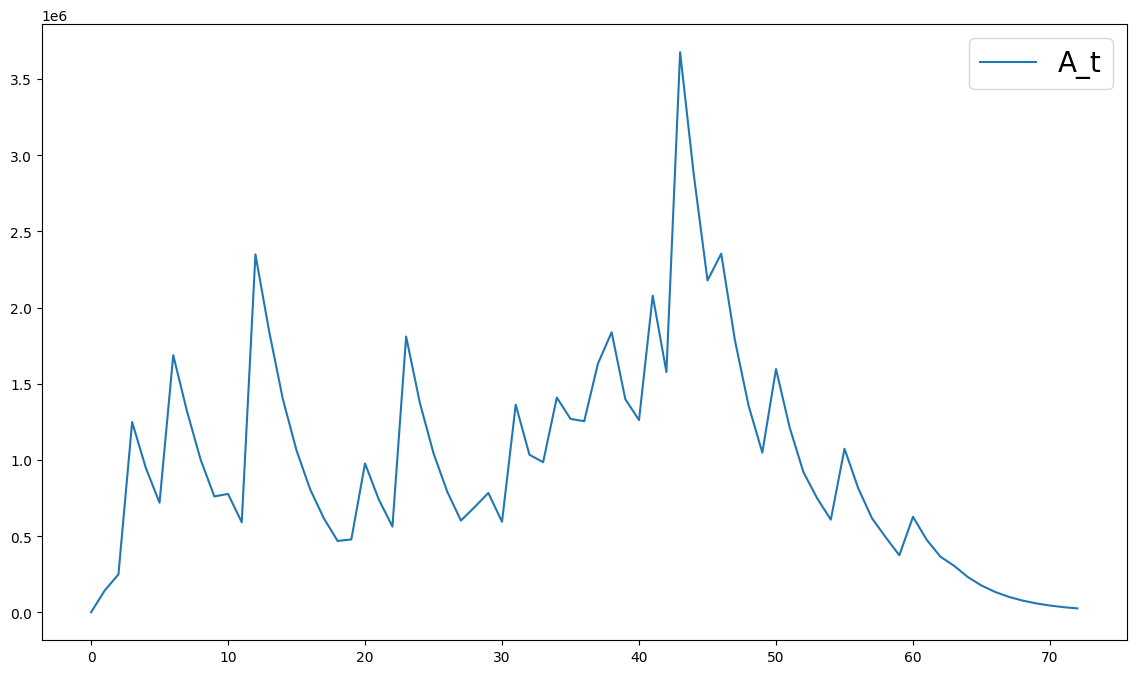

In [180]:
import numpy as np
from numba import njit, prange

V = F + lmbd * X_t
t_grid = np.asarray(t_grid, dtype=np.float64)
V = np.asarray(V, dtype=np.float64)
trades_history = np.asarray(trades_history, dtype=np.float64)
n_sim = int(n_sim)
s = float(s)
lmbd = float(lmbd)
r = float(r)

@njit
def compute_A_single(t_grid, V, s, lmbd, r, trades_history):
    N = t_grid.shape[0]
    A = np.empty(N, dtype=np.float64)
    for i in range(N):
        t_current = t_grid[i]
        sum_term = 0.0
        for j in range(trades_history.shape[0]):
            tau = trades_history[j, 0]
            if tau <= t_current:
                time_diff = t_current - tau
                sum_term += trades_history[j, 1] * np.exp(-r * time_diff)
            else:
                break
        A[i] = V[i] + s/2.0 + (1.0 / lmbd) * sum_term
    return A

@njit(parallel=True)
def simulate_A(n_sim, t_grid, V, s, lmbd, r, trades_history):
    N = t_grid.shape[0]
    A_result = np.empty((n_sim, N), dtype=np.float64)
    for sim in prange(n_sim):
        A_result[sim, :] = compute_A_single(t_grid, V, s, lmbd, r, trades_history)
    return A_result

A_result = simulate_A(n_sim, t_grid, V, s, lmbd, r, trades_history)
A = np.mean(A_result, axis=0)

plt.plot(A, label='A_t')
plt.legend(prop={'size': 20})
plt.show()


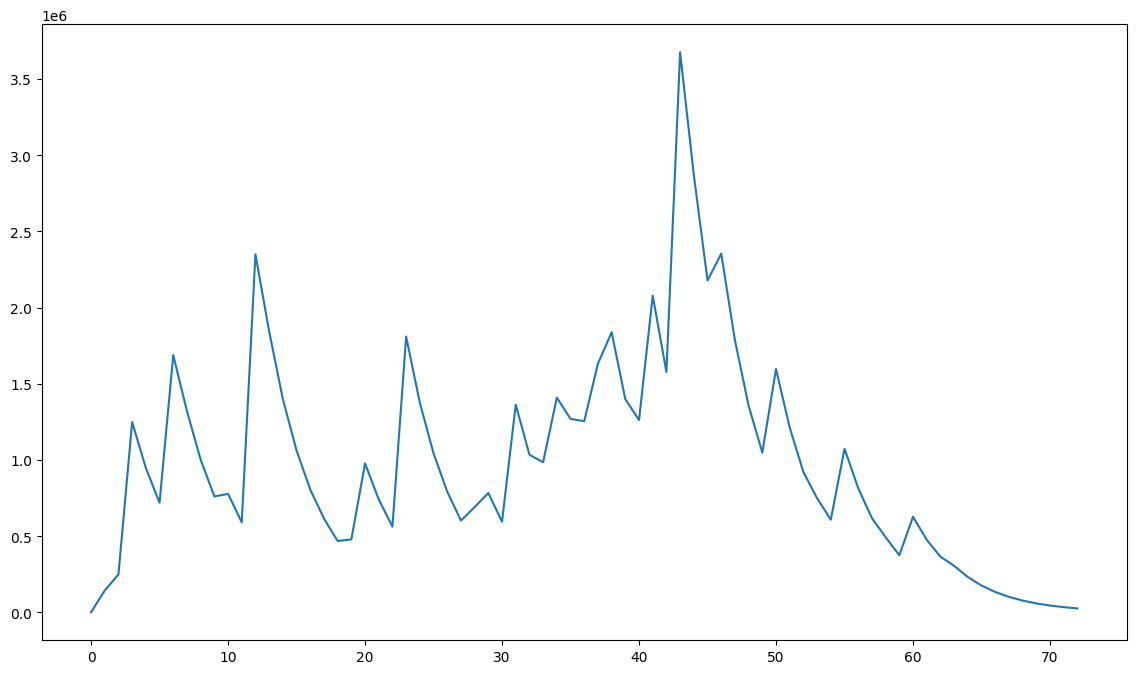

In [181]:
plt.plot(A)

In [182]:
trades_a = []
for i in range(len(trades)):
    trades_a.append(trades[i][0])
trades_a = np.array(trades_a)
trades_a.shape

(97,)

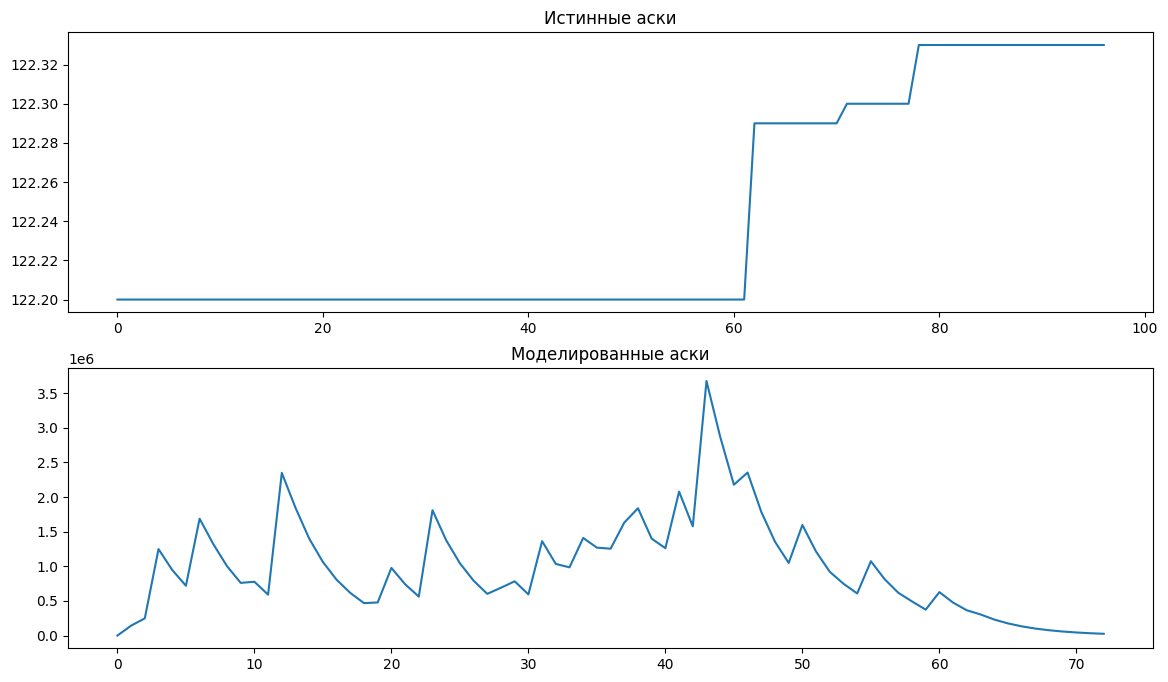

In [183]:
scaler = MinMaxScaler()
asks_sc = scaler.fit_transform(asks.reshape(-1, 1))
a_sc = scaler.transform(A.reshape(-1, 1))  # а не fit_transform!
# asks_aligned = np.array([order_books[i].ask_price() for i in range(start_val_idx, end_val_idx)])
# print(len(asks_aligned), len(A))  # должны совпадать

# Создание первого графика
plt.subplot(2, 1, 1) # указываем 2 строки, 1 столбец, выбираем первое место
plt.plot(np.arange(len(asks)), asks)
plt.title('Истинные аски')

# Создание второго графика
plt.subplot(2, 1, 2) # указываем 2 строки, 1 столбец, выбираем второе место
plt.plot(np.arange(len(A)), A)
plt.title('Моделированные аски')

plt.show()


Text(0.5, 1.0, 'Моделированные аски')

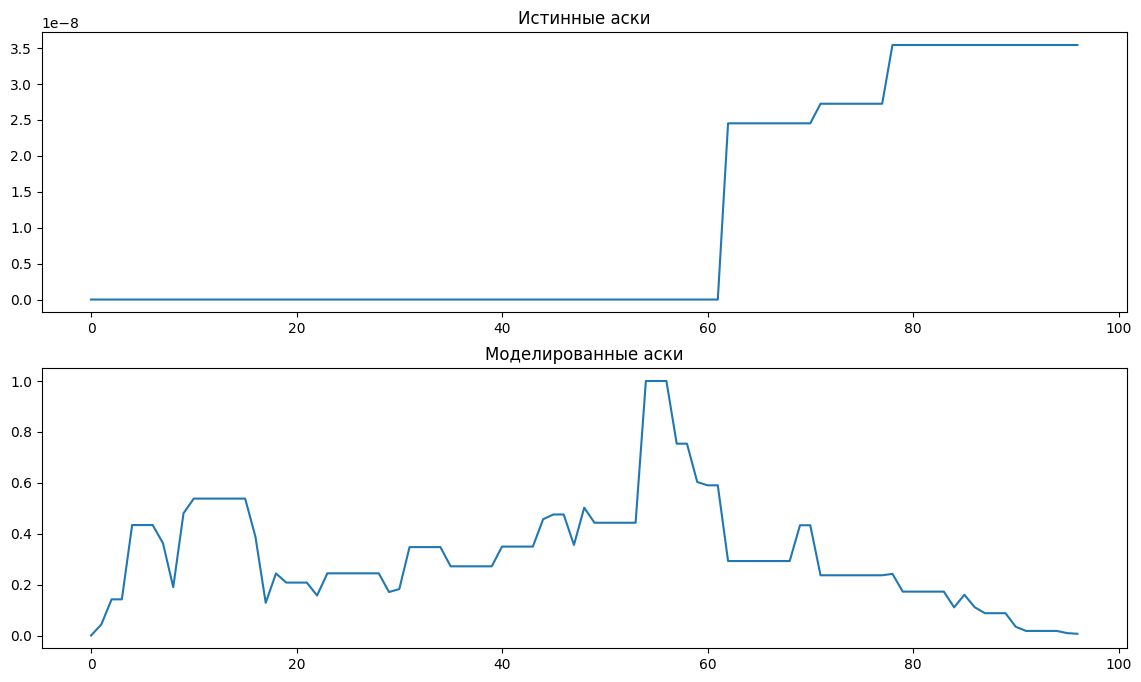

In [184]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import PchipInterpolator

# --- 1. Масштабирование trade_times в [0, 1], чтобы совпадали с t_grid ---
trade_times_scaled = (trade_times - trade_times.min()) / (trade_times.max() - trade_times.min())

# --- 2. Интерполяция A(t) на моменты trade_times ---
A_interp = PchipInterpolator(t_grid, A, extrapolate=True)
A_on_trades = A_interp(trade_times_scaled)

# --- 3. Масштабирование ask и A_on_trades в [0, 1] общей шкалой ---
scaler = MinMaxScaler()
all_data = np.concatenate([asks.reshape(-1, 1), A_on_trades.reshape(-1, 1)], axis=0)
scaler.fit(all_data)

asks_scaled = scaler.transform(asks.reshape(-1, 1)).ravel()
A_on_trades_scaled = scaler.transform(A_on_trades.reshape(-1, 1)).ravel()

# --- 4. Метрики ---
y_true = asks_scaled
y_pred = A_on_trades_scaled

plt.subplot(2, 1, 1) # указываем 2 строки, 1 столбец, выбираем первое место
plt.plot(np.arange(len(y_true)), y_true)
plt.title('Истинные аски')

# Создание второго графика
plt.subplot(2, 1, 2) # указываем 2 строки, 1 столбец, выбираем второе место
plt.plot(np.arange(len(y_pred)), y_pred)
plt.title('Моделированные аски')


# NOTES!!!
# Модель очень сильно зависит от калибровки параметра $\rho$, достаточно часто модель отрабатывает хорошо, но иногда бывают сбои ТЕСТ!!!
# Не понятно в каких масштабах мы работаем, вернее понятно что моделируется тренд и вроде как на масштаб все равно, но стоит подумтаь больше!